**This notebook was run on a CPU. If you decide to run it with a GPU, there may be extra packages you need to install.**

In [ ]:
! pip install -qU langchain_huggingface \
sentence-transformers \
langchain_community \
langchain_cohere \
langchain_groq \
langchainhub \
faiss-cpu \
pdf2image \
pymupdf \
gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.8/355.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.6/983.6 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.8/173.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
from google.colab import userdata

os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["COHERE_API_KEY"] = userdata.get('COHERE_API_KEY')
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

## **Run The Chatbot**

There are 2 ways you can run this chatbot:

* With Cohere: This has API call rate limits, but it works best.
* Without Cohere: For when you hit the API rate limit for Cohere. Doesn't work as well though.

**Cohere:**

In [ ]:
import os
import yaml
import json
from typing import List, Tuple
from operator import itemgetter
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.messages import BaseMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_groq import ChatGroq
from langchain_core.runnables import RunnableParallel
from langchain_core.runnables.history import RunnableWithMessageHistory
import logging
import gradio as gr
from langchain.schema import Document

class PDFChatbot:
    def __init__(self, config_path: str):
        """
        Initialize the PDFChatbot with the configuration from the given path.

        Args:
            config_path (str): The path to the configuration file.
        """
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)

        self.vector_store_model_name = config['vector_store']['model_name']
        self.vector_store_k = config['vector_store']['k']
        self.llm_model_name = config['llm']['model_name']
        self.llm_temperature = config['llm']['temperature']

        self.store = {}
        self.hf = SentenceTransformerEmbeddings(model_name=self.vector_store_model_name)
        self.llm = ChatGroq(temperature=self.llm_temperature, model_name=self.llm_model_name)

        # Load JSON data
        with open('/content/documents.json', 'r') as f:
            self.json_data = json.load(f)

        # Prepare data for vector store
        self.prepare_data()

    def prepare_data(self):
        """
        Prepare data for vector store.
        """
        chunks = []
        for course in self.json_data:
            for document in course['documents']:
                text = document['text']
                chunks.extend(self.chunk_data(text))
        self.faiss_index = FAISS.from_documents(chunks, self.hf)
        self.faiss_index.save_local("faiss_index")

    def get_by_session_id(self, session_id: str) -> BaseChatMessageHistory:
        """
        Get the chat message history for the given session ID.

        Args:
            session_id (str): The session ID.

        Returns:
            BaseChatMessageHistory: The chat message history for the session.
        """
        if session_id not in self.store:
            self.store[session_id] = self.InMemoryHistory()
        return self.store[session_id]

    class InMemoryHistory(BaseChatMessageHistory, BaseModel):
        """
        A chat message history that stores messages in memory.
        """
        messages: List[BaseMessage] = Field(default_factory=list)

        def add_messages(self, messages: List[BaseMessage]) -> None:
            """
            Add messages to the chat message history.

            Args:
                messages (List[BaseMessage]): The messages to add.
            """
            self.messages.extend(messages)

        def clear(self) -> None:
            """
            Clear the chat message history.
            """
            self.messages = []

    def process_query(self, query: str, history: List[List[str]] = []) -> List[List[str]]:
        """
        Process the query and answer using the chatbot.

        Args:
            query (str): The query to answer.
            history (List[List[str]], optional): The chat history. Defaults to an empty list.

        Returns:
            List[List[str]]: The updated chat history.
        """
        # Display a message indicating that the document(s) are being uploaded and processed
        print("Processing query...")

        # Define the prompt
        prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a Chatbot designed to assist with questions about the course.
                        You are to answer questions based on the provided history and context ONLY.
                        If the question is unrelated to the course, reply with ONLY this: 'I'm sorry, but 🅱🅻🅰🆀 will like us to only chat about the course.'
                        If you don't know the answer based on the provided information, reply with: 'I don't know.'
                        If asked about your emotions or feelings, reply with ONLY this: 'I'm sorry, but 🅱🅻🅰🆀 will like us to only chat about the course.'
                        If asked who you are, reply with 'I am a Chatbot for DataTalksClub's Data Engineering Course. What do you want to know?'
                        DO NOT BE CHATTY"""),
            MessagesPlaceholder(variable_name="history"),
            ("human", """Given this history: {history} and this context from the documents: {context}, answer the following question: {query}""")
        ])

        # Define the retriever and retrieval chain
        output_parser = StrOutputParser()
        retriever = self.faiss_index.as_retriever(search_kwargs={"k": self.vector_store_k})
        retrieval_chain = (
            {"context": itemgetter("query") | retriever, "query": itemgetter("query"), "history": itemgetter("history")}
            | RunnableParallel({"output": prompt | self.llm | StrOutputParser(), "context": itemgetter("context")})
        )

        logging.getLogger().setLevel(logging.ERROR)  # hide warning log

        # Define the retrieval_chain_with_history
        retrieval_chain_with_history = RunnableWithMessageHistory(
            retrieval_chain,
            self.get_by_session_id,
            input_messages_key="query",
            history_messages_key="history",
        )
        result = retrieval_chain_with_history.invoke({"query": query, "history": history}, config={"configurable": {"session_id": "foo"}})
        history.append([query, result["output"]])
        return history

    def chunk_data(self, text: str) -> List[Document]:
        """
        Chunk the given text data.

        Args:
            text (str): The text data.

        Returns:
            List[Document]: The chunks of text as Document objects.
        """
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=500,
            chunk_overlap=20,
            length_function=len,
            is_separator_regex=False
        )
        chunks = text_splitter.split_documents([Document(page_content=text)])
        return chunks

    def create_demo(self) -> Tuple[gr.Blocks, gr.Chatbot, gr.Textbox, gr.Button]:
        """
        Create the Gradio demo for the chatbot.

        Returns:
            Tuple[gr.Blocks, gr.Chatbot, gr.Textbox, gr.Button]: The Gradio demo components.
        """
        with gr.Blocks(title="DataTalksClub Data Engineering Zoomcamp Chatbot powered by 🅱🅻🅰🆀", theme=gr.themes.Glass(primary_hue=gr.themes.colors.red, secondary_hue=gr.themes.colors.pink)) as demo:
            with gr.Column():
                gr.HTML("<h1>DataTalksClub Data Engineering Zoomcamp Chatbot powered by 🅱🅻🅰🆀</h1>")
                with gr.Row():
                    chat_history = gr.Chatbot(value=[], elem_id='chatbot', height=500)

                with gr.Row():
                    with gr.Column(scale=8):
                        query = gr.Textbox(
                            show_label=False,
                            placeholder="Enter your chat here",
                            container=False
                        )

                    with gr.Column(scale=1):
                        submit_btn = gr.Button('Send')

                submit_btn.click(self.process_query, inputs=[query, chat_history], outputs=[chat_history])

        return demo, chat_history, query, submit_btn

if __name__ == '__main__':
    chatbot = PDFChatbot('config.yaml')
    demo, chat_history, query, submit_btn = chatbot.create_demo()
    demo.launch(debug=True, share=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://8fb55ffc54c55c26ce.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Processing query...
Processing query...
Processing query...
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8fb55ffc54c55c26ce.gradio.live


You can click on the link provided in the tunnel inorder to use this chatbot in your browser.

**Without Cohere:**

In [ ]:
import os
import yaml
import json
from typing import List, Tuple
from operator import itemgetter
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.messages import BaseMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_groq import ChatGroq
from langchain_core.runnables import RunnableParallel
from langchain_core.runnables.history import RunnableWithMessageHistory
import logging
import gradio as gr
from langchain.schema import Document

class PDFChatbot:
    def __init__(self, config_path: str):
        """
        Initialize the PDFChatbot with the configuration from the given path.

        Args:
            config_path (str): The path to the configuration file.
        """
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)

        self.vector_store_model_name = config['vector_store']['model_name']
        self.vector_store_k = config['vector_store']['k']
        self.llm_model_name = config['llm']['model_name']
        self.llm_temperature = config['llm']['temperature']

        self.store = {}
        self.hf = SentenceTransformerEmbeddings(model_name=self.vector_store_model_name)
        self.llm = ChatGroq(temperature=self.llm_temperature, model_name=self.llm_model_name)

        # Load JSON data
        with open('/content/documents.json', 'r') as f:
            self.json_data = json.load(f)

        # Prepare data for vector store
        self.prepare_data()

    def prepare_data(self):
        """
        Prepare data for vector store.
        """
        chunks = []
        for course in self.json_data:
            for document in course['documents']:
                text = document['text']
                chunks.extend(self.chunk_data(text))
        self.faiss_index = FAISS.from_documents(chunks, self.hf)
        self.faiss_index.save_local("faiss_index")

    def get_by_session_id(self, session_id: str) -> BaseChatMessageHistory:
        """
        Get the chat message history for the given session ID.

        Args:
            session_id (str): The session ID.

        Returns:
            BaseChatMessageHistory: The chat message history for the session.
        """
        if session_id not in self.store:
            self.store[session_id] = self.InMemoryHistory()
        return self.store[session_id]

    class InMemoryHistory(BaseChatMessageHistory, BaseModel):
        """
        A chat message history that stores messages in memory.
        """
        messages: List[BaseMessage] = Field(default_factory=list)

        def add_messages(self, messages: List[BaseMessage]) -> None:
            """
            Add messages to the chat message history.

            Args:
                messages (List[BaseMessage]): The messages to add.
            """
            self.messages.extend(messages)

        def clear(self) -> None:
            """
            Clear the chat message history.
            """
            self.messages = []

    def process_query(self, query: str, history: List[List[str]] = []) -> List[List[str]]:
        """
        Process the query and answer using the chatbot.

        Args:
            query (str): The query to answer.
            history (List[List[str]], optional): The chat history. Defaults to an empty list.

        Returns:
            List[List[str]]: The updated chat history.
        """
        # Display a message indicating that the document(s) are being uploaded and processed
        print("Processing query...")

        # Define the prompt
        prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a Chatbot designed to assist with questions about the course.
                        You are to answer questions based on the provided history and context ONLY.
                        If the question is unrelated to the course, reply with: 'I'm sorry, but 🅱🅻🅰🆀 will like us to only chat about the course.'
                        If you don't know the answer based on the provided information, reply with: 'I don't know.'
                        If asked about your emotions or feelings, reply with: 'I'm sorry, but 🅱🅻🅰🆀 will like us to only chat about the course.'
                        If asked who you are, reply with 'I am a Chatbot for DataTalksClub's Data Engineering Course. What do you want to know?'
                        DO NOT BE CHATTY"""),
            MessagesPlaceholder(variable_name="history"),
            ("human", """Given this history: {history} and this context from the documents: {context}, answer the following question: {query}""")
        ])

        # Define the retriever and retrieval chain
        output_parser = StrOutputParser()
        retriever = self.faiss_index.as_retriever(search_kwargs={"k": self.vector_store_k})
        retrieval_chain = (
            {"context": itemgetter("query") | retriever, "query": itemgetter("query"), "history": itemgetter("history")}
            | RunnableParallel({"output": prompt | self.llm | StrOutputParser(), "context": itemgetter("context")})
        )

        logging.getLogger().setLevel(logging.ERROR)  # hide warning log

        # Define the retrieval_chain_with_history
        retrieval_chain_with_history = RunnableWithMessageHistory(
            retrieval_chain,
            self.get_by_session_id,
            input_messages_key="query",
            history_messages_key="history",
        )
        result = retrieval_chain_with_history.invoke(
            {"query": query, "history": history},
            config={"configurable": {"session_id": "default-session-id"}}
        )
        history.append([query, result["output"]])
        return history

    def chunk_data(self, text: str) -> List[Document]:
        """
        Chunk the given text data.

        Args:
            text (str): The text data.

        Returns:
            List[Document]: The chunks of text as Document objects.
        """
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=500,
            chunk_overlap=20,
            length_function=len,
            is_separator_regex=False
        )
        chunks = text_splitter.split_documents([Document(page_content=text)])
        return chunks

    def create_demo(self) -> Tuple[gr.Blocks, gr.Chatbot, gr.Textbox, gr.Button]:
        """
        Create the Gradio demo for the chatbot.

        Returns:
            Tuple[gr.Blocks, gr.Chatbot, gr.Textbox, gr.Button]: The Gradio demo components.
        """
        with gr.Blocks(title="DataTalksClub Data Engineering Zoomcamp Chatbot powered by 🅱🅻🅰🆀", theme=gr.themes.Glass(primary_hue=gr.themes.colors.red, secondary_hue=gr.themes.colors.pink)) as demo:
            with gr.Column():
                gr.HTML("<h1>DataTalksClub Data Engineering Zoomcamp Chatbot powered by 🅱🅻🅰🆀</h1>")
                with gr.Row():
                    chat_history = gr.Chatbot(value=[], elem_id='chatbot', height=500)

                with gr.Row():
                    with gr.Column(scale=8):
                        query = gr.Textbox(
                            show_label=False,
                            placeholder="Type here to ask about the course",
                            container=False
                        )

                    with gr.Column(scale=1):
                        submit_btn = gr.Button('Send')

                submit_btn.click(self.process_query, inputs=[query, chat_history], outputs=[chat_history])

        return demo, chat_history, query, submit_btn

if __name__ == '__main__':
    chatbot = PDFChatbot('config.yaml')
    demo, chat_history, query, submit_btn = chatbot.create_demo()
    demo.launch(debug=True, share=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://e2409b7ebc853d98e2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Processing query...
Processing query...
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e2409b7ebc853d98e2.gradio.live


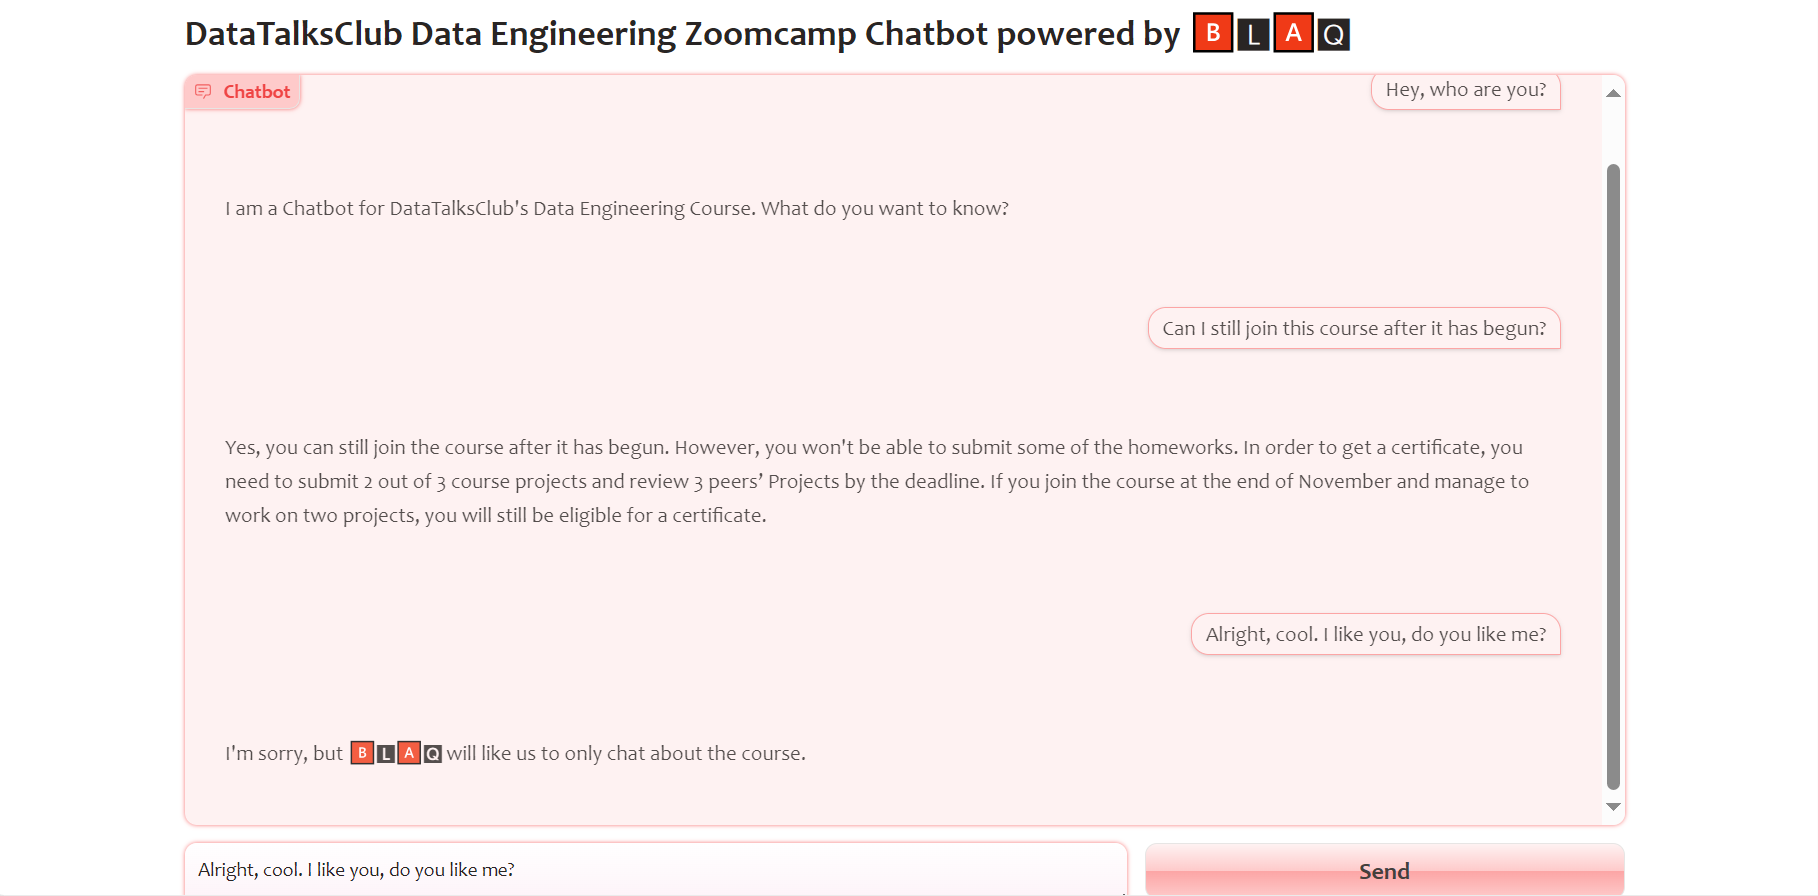